<font size="6"> **Portfolio Optimization** </font>

$$ \vec{r}(N,T) = \vec{\beta}(N,K) · \vec{f}(K,T) + \vec{s}(N,T)$$

* from $\vec{f}$ compute `factor covariance matrix`: $\vec{F}$
* from $\vec{s}$ compute `idiosyncratic covariance matrix` $\vec{S}$ and extract diagonal

Use  $\vec{\beta}$, $\vec{F}$ and $\vec{S}$ to estimate portfolio risk: $\sigma_{r_{p}}$

In [1]:
%%capture
%run 01_portopt_data.ipynb

In [2]:
import matplotlib.pyplot as plt
import scipy
import pickle
import datetime as dt

from mle_quant_utils import portopt_utils
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

In [4]:
RND_SEED = 123
STR_DATE_FMT = "%Y%m%d"

universe_start_date = test_dates[0]
universe_end_date = test_dates[-1]
min_mkt_cap = float(cfg['backtesting']['min_mkt_cap'])
risk_aversion = float(cfg['backtesting']['risk_aversion'])


In [5]:
daily_returns = daily_returns[universe_start_date:universe_end_date].copy()
pd.concat([daily_returns.head(2), daily_returns.tail(2)],axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-05-28 00:00:00+00:00,-4.343143,-1.387602,0.121663,-1.106933,-0.930783,-1.824873,-0.396733,-0.795519,-1.180581,-0.989702,...,0.811210,-0.882280,-1.000000,-0.605109,-0.689255,0.249423,-1.405459,-1.737738,-1.462557,-1.219448
2015-05-29 00:00:00+00:00,1.715641,-2.494271,2.617707,4.695390,-10.727698,0.109932,-3.630394,-7.203142,5.390871,-19.050437,...,-1.334927,-3.816060,inf,-1.408702,-2.137564,-1.642314,8.448164,-1.801041,0.714105,-2.956199
2015-12-24 00:00:00+00:00,-1.311973,0.304040,-0.944139,-1.414993,-1.118802,-0.988058,-1.000000,-1.285938,-1.450322,-0.316175,...,0.046096,-1.065262,-1.327937,-1.280433,-0.503892,-1.093624,-1.105569,-0.866521,-0.788249,-0.426651
2015-12-28 00:00:00+00:00,-2.911899,-2.102883,19.483228,1.097846,-3.426971,24.553246,-inf,-0.208504,-0.748940,-2.086551,...,-0.947725,0.715349,-0.306336,-3.317430,-4.806676,1.158656,0.343641,-5.701616,-2.265995,-2.532631


In [6]:
def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        _h0 = h0.values
        factor_risk = 0.5*risk_aversion*np.sum( np.matmul(Q,h)**2 )
        idiosyncratic_risk = 0.5*risk_aversion*np.dot(h**2, specVar)  # specVar is diag
        exp_port_ret = np.dot(h, alpha_vec)
        trans_costs = np.dot((h-_h0)**2, Lambda)
        obj_f = factor_risk + idiosyncratic_risk - exp_port_ret + trans_costs
        return(obj_f)
    
    return obj_func

In [7]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        
        grad_factor_risk = risk_aversion*np.matmul(QT, np.matmul(Q,h))
        grad_idiosyncratic_risk = risk_aversion*specVar*h
        grad_exp_port_ret =  alpha_vec
        grad_trans_costs = 2*(h-h0)*Lambda
        
        g = grad_factor_risk + grad_idiosyncratic_risk - grad_exp_port_ret + grad_trans_costs
        return(np.asarray(g))
    
    return grad_func

In [8]:
def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)


    optimizer_result = scipy.optimize.fmin_l_bfgs_b(
        func=obj_func, x0=h0, fprime=grad_func
    )
    return optimizer_result[0]

In [9]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_returns', 'factor_betas', 'factor_var_vector'])

In [10]:
risk_facret = risk_model['factor_returns']
#alpha_facret

In [11]:
B = risk_model['factor_betas']
B.shape

(490, 20)

In [12]:
Fvar = np.diag(risk_model['factor_var_vector'].values[:,0])
Fvar.shape

(20, 20)

In [13]:
# alphas
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed']
B_alpha = features_df[alpha_factors]
alpha_vec = B_alpha.sum(axis=1)
alpha_vec.name = 'ML_FACTOR'
alpha_vec[:5]

date                       asset
2013-01-03 00:00:00+00:00  A       -3.327787
                           AAL      0.639552
                           AAP     -1.567522
                           AAPL     0.085905
                           ABBV    -1.949210
Name: ML_FACTOR, dtype: float64

In [14]:
previous_holdings = pd.DataFrame(data = {"asset" : ["A"], "h.opt.previous" : np.array(0)}).set_index('asset')
previous_holdings

,h.opt.previous
asset,
A,0


In [15]:
def get_universe(mkt_cap, min_mkt_cap, h_prev, dt_idx):
    universe = mkt_cap.loc[dt_idx] > min_mkt_cap
    universe = universe[universe]
    universe = universe.index.union(h_prev.index)
    universe.name = 'asset'
    return universe
    

In [16]:
# data alignment: static frame
bkt_dates = mkt_cap.loc[universe_start_date:universe_end_date].index

mkt_caps = {}
betas_exp = {}
alphas_vec = {}
# factor_cov = {}
spec_var = {}
lambdas = {}

for dt_idx in bkt_dates:
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    universe = pd.Index(universe_tickers)
    #universe = get_universe(mkt_cap, min_mkt_cap, previous_holdings, dt_idx)
    #universe = pd.Index(['AMZN', 'MSFT', 'AAPL', 'GOOG'])
    #universe.name = 'asset'
    betas_exp[dt_idx_str] = B.loc[universe]
    spec_var[dt_idx_str] = risk_model['idiosyncratic_var_vector'].loc[universe, '0']
    alphas_vec[dt_idx_str] = alpha_vec.loc[dt_idx][universe]*1e-4
    lambdas[dt_idx_str] = 0.1 / adv.loc[dt_idx, universe]

In [43]:
example_dt = dt.datetime.strftime(universe_start_date, STR_DATE_FMT)

# universe
ex_universe = pd.Index(['AMZN', 'MSFT', 'AAPL', 'GOOG'])
ex_universe.name = 'asset'
# alpha
current_alpha_vec = alphas_vec[example_dt].loc[ex_universe]
# risk
BT = betas_exp[example_dt].loc[ex_universe].T
Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()
specVar = spec_var[example_dt].loc[ex_universe]
# cost
Lambda = lambdas[example_dt].loc[ex_universe]
# previous holidng
h0 = pd.Series(index=current_alpha_vec.index, data=np.zeros(len(current_alpha_vec)))

In [45]:
BT.shape, Q.shape, specVar.shape

((20, 4), (20, 4), (4,))

In [48]:
current_alpha_vec[:5]

asset
AMZN    0.000099
MSFT   -0.000010
AAPL    0.000155
GOOG   -0.000283
Name: ML_FACTOR, dtype: float64

In [46]:
h_star = get_h_star(risk_aversion, Q, QT, specVar, current_alpha_vec, h0, Lambda)
h_star[:5]

array([  894.18941725, -1358.42737963,  2878.3387873 , -3333.52611795])

In [47]:
h_star.sum()

-919.4252930232215

In [22]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    return np.dot(Lambda, (h_star-h0)**2)

In [23]:
total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
total_transaction_costs

0.0

In [24]:
def get_risk_exposures(BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    # TODO: Implement
    factor_names = BT.index
    risk_exposures = np.dot(BT, h_star)
    return pd.Series(index=factor_names, data=risk_exposures)



In [25]:
risk_exposures = get_risk_exposures(BT, h_star)
risk_exposures[:5]

0    -62.133261
1    -20.176190
2   -128.535918
3    -40.589410
4     -2.763479
dtype: float64

In [26]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    if isinstance(B_alpha, pd.Series):
        alpha_factor_names = [B_alpha.name]
    elif isinstance(B_alpha, pd.DataFrame):
        alpha_factor_names = B_alpha.columns
    else:
        alpha_factor_names = range(0,B_alpha.shape[1])
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index=alpha_factor_names)
    

In [27]:
portfolio_alpha_exposure = get_portfolio_alpha_exposure(current_alpha_vec, h_star)
portfolio_alpha_exposure[:5]

ML_FACTOR    1.493539
dtype: float64

In [57]:
def form_optimal_portfolio(universe, previous_holdings, risk_aversion, Fvar, betas_exp, alphas_vec, spec_var, lambdas, dt_idx):
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    
    #universe = pd.Index(['AMZN', 'MSFT', 'AAPL', 'GOOG'])
    #universe.name = 'asset'
    universe_s = pd.DataFrame(index=universe, data= np.zeros(len(universe)), columns=['universe'])
    h_prev = universe_s.join(previous_holdings, how='outer').fillna(0.0)['h.opt.previous']
    
    # Beta exposures
    B = betas_exp[dt_idx_str].loc[universe]
    BT = B.transpose()
    # Factor covariance matrix
    # Fvar as argument
    # Specific variance
    specVar = spec_var[dt_idx_str].loc[universe]
    # Transaction costs
    Lambda = lambdas[dt_idx_str].loc[universe]
    # alpha factor
    alpha_vec = alphas_vec[dt_idx_str].loc[universe]#*1e-4
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    #print(universe.shape, BT.shape, Fvar.shape, specVar.shape, alpha_vec.shape, Lambda.shape)
    #print(alpha_vec.isna().sum())
    nans = alpha_vec.isna()
    if any(nans):
        print(dt_idx_str)
        print(nans.sum())
        print(alpha_vec[nans])
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h_prev, Lambda)


    opt_portfolio = pd.DataFrame(data = {"asset" : universe, "h.opt" : h_star}).set_index('asset')
    
    risk_exposures = get_risk_exposures(BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(alpha_vec, h_star)
    total_transaction_costs = get_total_transaction_costs(h_prev, h_star, Lambda)
    
    result = {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}
    return result

In [58]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

In [59]:
def build_tradelist(prev_holdings, opt_result):
    tmp = opt_result['opt.portfolio'].join(prev_holdings, how='outer')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

In [60]:
trades = {}
port = {}

bkt_dates = mkt_cap.loc[universe_start_date:universe_end_date].index
previous_holdings = h0
previous_holdings.name = 'h.opt.previous'

for dt_idx in tqdm(bkt_dates, desc='Optimizing Portfolio', unit='day'):
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    universe = get_universe(mkt_cap, min_mkt_cap, previous_holdings, dt_idx)
    result = form_optimal_portfolio(universe, previous_holdings,  risk_aversion, Fvar, betas_exp, alphas_vec, spec_var, lambdas, dt_idx)
    trades[dt_idx_str] = build_tradelist(previous_holdings, result)
    port[dt_idx_str] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio:  19%|█▉        | 29/149 [00:01<00:07, 17.10day/s]

20150706
1
asset
KHC   NaN
Name: ML_FACTOR, dtype: float64


Optimizing Portfolio:  28%|██▊       | 41/149 [00:02<00:04, 23.63day/s]

20150720
1
asset
PYPL   NaN
Name: ML_FACTOR, dtype: float64


Optimizing Portfolio:  77%|███████▋  | 115/149 [00:05<00:01, 19.80day/s]

20151102
1
asset
HPE   NaN
Name: ML_FACTOR, dtype: float64


Optimizing Portfolio:  89%|████████▉ | 133/149 [00:06<00:00, 24.46day/s]

20151130
1
asset
CSRA   NaN
Name: ML_FACTOR, dtype: float64


Optimizing Portfolio: 100%|██████████| 149/149 [00:07<00:00, 21.05day/s]


In [ ]:
# Fix NaNs

In [61]:
result.keys()

dict_keys(['opt.portfolio', 'risk.exposures', 'total.cost', 'alpha.exposures'])

In [62]:
port['20151028']['opt.portfolio'].sample(5)

,h.opt
asset,
K,-1206.220257
XEC,4253.927171
FTI,189.991461
ALB,2616.805320
ED,-4472.857740


In [34]:
alpha_facret = pd.read_csv(INPATH_ALPHA + INFILE3, parse_dates=['date'])
alpha_facret['date'] = alpha_facret['date'].dt.tz_localize('utc')
alpha_facret.set_index('date', inplace=True)

In [63]:
alpha_facret[:2]

,Mean_Reversion_Sector_Neutral_Smoothed,Overnight_Sentiment_Smoothed,ML_FACTOR,Momentum_1YR_Smoothed
date,,,,
2013-01-04 00:00:00+00:00,0.002945,0.003614,-0.001818,-0.000536
2013-01-07 00:00:00+00:00,0.002268,0.002030,-0.000622,-0.001868


In [71]:
daily_returns.loc['2015-10-28'].head()

A       -1.325742
AAL     57.412905
AAP      0.227903
AAPL    -7.509506
ABBV    -0.056143
Name: 2015-10-28 00:00:00+00:00, dtype: float64

In [73]:
port['20151028']['opt.portfolio'].head()

,h.opt
asset,
A,5152.225330
AAL,-7046.957518
AAP,2294.031515
AAPL,-4875.649608
ABBV,2013.665200


In [113]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 
    wins_ret = 0.25
    df = pd.DataFrame(index = bkt_dates)
    # Static factor returns
    risk_fr = risk_model['factor_returns']
    alpha_fr = alpha_facret
        
    for dt_idx in bkt_dates:
        dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
        p = port[dt_idx_str]
        wins_returns = np.clip(daily_returns.loc[dt_idx],-wins_ret,wins_ret).to_frame('DlyReturn')
        mf = p['opt.portfolio'].join(wins_returns, how = 'left')
        df.at[dt_idx,"daily.pnl"] = partial_dot_product(mf['h.opt'], mf['DlyReturn'] )
        
        #df.at[dt_idx,"attribution.alpha.pnl"] = partial_dot_product(alpha_fr, p['alpha.exposures'])
        #df.at[dt_idx,"attribution.risk.pnl"] = partial_dot_product(risk_fr, p['risk.exposures'])
        df.at[dt_idx,"attribution.cost"] = p['total.cost']
        
    return df

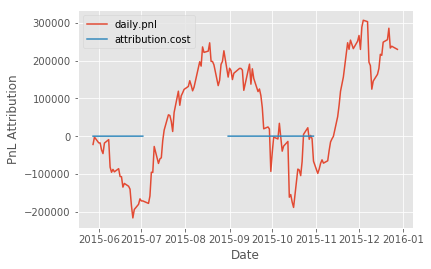

In [114]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [112]:
attr['daily.pnl']

date
2015-05-28 00:00:00+00:00    -9724.174340
2015-05-29 00:00:00+00:00     8235.832403
2015-06-01 00:00:00+00:00    -5779.612632
2015-06-02 00:00:00+00:00    -1572.598350
2015-06-03 00:00:00+00:00   -10127.872524
2015-06-04 00:00:00+00:00    -5534.952115
2015-06-05 00:00:00+00:00     9027.169079
2015-06-08 00:00:00+00:00     3066.245362
2015-06-09 00:00:00+00:00   -27970.450184
2015-06-10 00:00:00+00:00    -6441.672581
2015-06-11 00:00:00+00:00     1879.812574
2015-06-12 00:00:00+00:00    -2930.185067
2015-06-15 00:00:00+00:00     7130.550615
2015-06-16 00:00:00+00:00    -6806.082198
2015-06-17 00:00:00+00:00    -1455.737739
2015-06-18 00:00:00+00:00   -14245.527105
2015-06-19 00:00:00+00:00     3870.272758
2015-06-22 00:00:00+00:00    -2912.655990
2015-06-23 00:00:00+00:00    -6281.791612
2015-06-24 00:00:00+00:00   -19466.245169
2015-06-25 00:00:00+00:00   -12710.410800
2015-06-26 00:00:00+00:00     7923.037322
2015-06-29 00:00:00+00:00     6137.558643
2015-06-30 00:00:00+00:00    